# ✒️ Code Modules, Links and Helpful Functions
#### [📑 GitHub Repository](https://github.com/OlgaBelitskaya/deep_learning_projects/tree/master/DL_PP2) & [📑 Colaboratory](https://colab.research.google.com/drive/1Z9Fz0OOi6bpWvH-H2OhExC9CkGPWBYZz)
#### [📑 Full Version - Python](https://olgabelitskaya.github.io/kaggle_letters.html) & [📑 Full Version - R](https://olgabelitskaya.github.io/kaggle_letters_R.html) 
#### [📑 Deep Learning. P2: Multi-Label Classification. Letter Recognition](https://olgabelitskaya.github.io/DL_PP2_Solutions_SMC.html)

In [1]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pandas as pd,pylab as pl,h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from IPython import display
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.metrics import top_k_categorical_accuracy,categorical_accuracy
from keras.models import Sequential,load_model,Model
from keras.layers import Dense,LSTM,GlobalAveragePooling1D,GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
from keras.layers import Input,Activation,Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,GlobalMaxPooling2D
fw='weights.best.letters.hdf5'

Using TensorFlow backend.


In [2]:
# plotting of fitting histories for neural networks
def history_plot(fit_history):
    pl.figure(figsize=(12,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='#4876ff',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='#4876ff',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()
# preprocessing functions 
def ohe(x): 
    return OneHotEncoder(categories='auto')\
           .fit(x.reshape(-1,1)).transform(x.reshape(-1,1))\
           .toarray().astype('int64')
def tts(X,y): 
    x_train,x_test,y_train,y_test=\
    train_test_split(X,y,test_size=.2,random_state=1)
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    return x_train,x_valid,x_test,y_train,y_valid,y_test

# ✒️ Loading and Preprocessing the Data

In [3]:
f=h5py.File('../input/LetterColorImages_123.h5','r')
keys=list(f.keys()); keys 

['backgrounds', 'images', 'labels']

In [4]:
# creating image arrays and targets
letters=u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
backgrounds=np.array(f[keys[0]])
labels=np.array(f[keys[2]])
# normalization of image arrays
images=np.array(f[keys[1]])/255

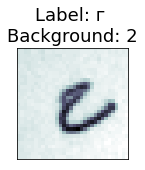

In [5]:
gray_images=np.dot(images[...,:3],[.299,.587,.114])
rn=np.random.randint(10000); pl.figure(figsize=(2,3))
pl.title('Label: %s \n'%letters[labels[rn]-1]+\
         'Background: %s'%backgrounds[rn],
         fontsize=18)
pl.imshow(gray_images[rn],cmap=pl.cm.bone)
pl.xticks([]); pl.yticks([]); pl.show()
gray_images=gray_images.reshape(-1,32,32,1)

In [6]:
# one-hot encoding
cbackgrounds,clabels=ohe(backgrounds),ohe(labels)
ctargets=np.concatenate((clabels,cbackgrounds),axis=1)
display.display(pd.DataFrame([labels[97:103],clabels[97:103]]).T)
pd.DataFrame([clabels.shape,cbackgrounds.shape,ctargets.shape])

,0,1
0,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


,0,1
0,14190,33
1,14190,4
2,14190,37


In [7]:
# splitting the data
x_train1,x_valid1,x_test1,\
y_train1,y_valid1,y_test1=tts(gray_images,clabels)
x_train2,x_valid2,x_test2,\
y_train2,y_valid2,y_test2=tts(gray_images,ctargets)
y_train2_list=[y_train2[:,:33],y_train2[:,33:]]
y_test2_list=[y_test2[:,:33],y_test2[:,33:]]
y_valid2_list=[y_valid2[:,:33],y_valid2[:,33:]]

# ✒️ Defining a Classification Model

In [8]:
def top_3_categorical_accuracy(y_true,y_pred):
    return top_k_categorical_accuracy(y_true,y_pred,k=3)
def gray_model():
    model = Sequential()    
    model.add(Conv2D(32,(5,5),padding='same',
                     input_shape=x_train1.shape[1:]))
    model.add(LeakyReLU(alpha=.02))    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.25))
    model.add(Conv2D(128,(5,5)))
    model.add(LeakyReLU(alpha=.02))    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.25))   
    model.add(GlobalMaxPooling2D())  
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=.02)) 
    model.add(Dropout(.25))  
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=.02)) 
    model.add(Dropout(.25))    
    model.add(Dense(33))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop',
                  metrics=[categorical_accuracy,top_3_categorical_accuracy])
    return model
gray_model=gray_model()

In [9]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss', 
                               patience=10,verbose=2,factor=.5)
estopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
history=gray_model.fit(x_train1,y_train1, 
                       epochs=200,batch_size=64,verbose=2,
                       validation_data=(x_valid1,y_valid1),
                       callbacks=[checkpointer,lr_reduction,estopping])

Train on 11352 samples, validate on 1419 samples
Epoch 1/200
 - 20s - loss: 3.4883 - categorical_accuracy: 0.0347 - top_3_categorical_accuracy: 0.1032 - val_loss: 3.4407 - val_categorical_accuracy: 0.0479 - val_top_3_categorical_accuracy: 0.1494

Epoch 00001: val_loss improved from inf to 3.44066, saving model to weights.best.letters.hdf5
Epoch 2/200
 - 19s - loss: 3.4306 - categorical_accuracy: 0.0462 - top_3_categorical_accuracy: 0.1357 - val_loss: 3.4468 - val_categorical_accuracy: 0.0338 - val_top_3_categorical_accuracy: 0.1071

Epoch 00002: val_loss did not improve from 3.44066
Epoch 3/200
 - 20s - loss: 3.4109 - categorical_accuracy: 0.0507 - top_3_categorical_accuracy: 0.1490 - val_loss: 3.3852 - val_categorical_accuracy: 0.0599 - val_top_3_categorical_accuracy: 0.1635

Epoch 00003: val_loss improved from 3.44066 to 3.38523, saving model to weights.best.letters.hdf5
Epoch 4/200
 - 20s - loss: 3.3500 - categorical_accuracy: 0.0612 - top_3_categorical_accuracy: 0.1785 - val_loss: 

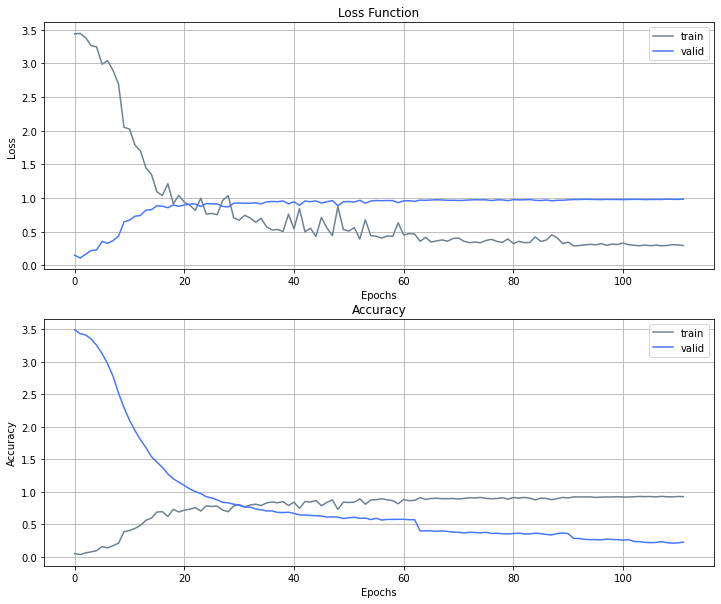

1419/1419 [==============================] - 1s 515us/step


[0.3236396277849736, 0.9034531116485596, 0.9809725284576416]

In [10]:
history_plot(history)
# loading the model weights with the best validation accuracy
gray_model.load_weights(fw)
# calculation classification accuracy on the testing set
gray_model.evaluate(x_test1,y_test1)

In [11]:
steps,epochs=1000,10
igen=ImageDataGenerator(zoom_range=.3,shear_range=.3,rotation_range=30)
generator=\
gray_model.fit_generator(igen.flow(x_train1,y_train1,batch_size=64),
                         steps_per_epoch=steps,epochs=epochs,verbose=2,
                         validation_data=(x_valid1,y_valid1), 
                         callbacks=[checkpointer,lr_reduction])

Epoch 1/10
 - 115s - loss: 1.5497 - categorical_accuracy: 0.5957 - top_3_categorical_accuracy: 0.7829 - val_loss: 0.3198 - val_categorical_accuracy: 0.9112 - val_top_3_categorical_accuracy: 0.9718

Epoch 00001: val_loss did not improve from 0.28748
Epoch 2/10
 - 114s - loss: 1.3419 - categorical_accuracy: 0.6334 - top_3_categorical_accuracy: 0.8219 - val_loss: 0.3199 - val_categorical_accuracy: 0.9091 - val_top_3_categorical_accuracy: 0.9739

Epoch 00002: val_loss did not improve from 0.28748
Epoch 3/10
 - 114s - loss: 1.2685 - categorical_accuracy: 0.6511 - top_3_categorical_accuracy: 0.8359 - val_loss: 0.3087 - val_categorical_accuracy: 0.9119 - val_top_3_categorical_accuracy: 0.9732

Epoch 00003: val_loss did not improve from 0.28748
Epoch 4/10
 - 131s - loss: 1.2225 - categorical_accuracy: 0.6622 - top_3_categorical_accuracy: 0.8430 - val_loss: 0.3094 - val_categorical_accuracy: 0.9190 - val_top_3_categorical_accuracy: 0.9718

Epoch 00004: val_loss did not improve from 0.28748
Epoc

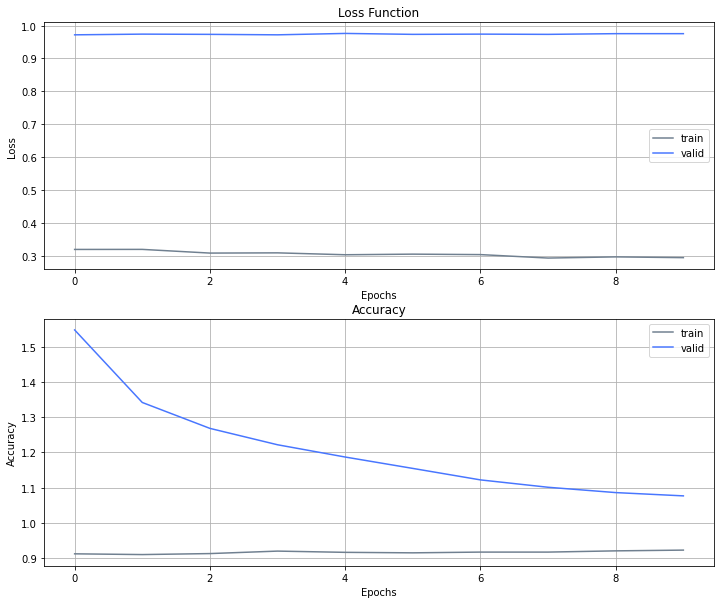

1419/1419 [==============================] - 1s 501us/step


[0.3236396277849736, 0.9034531116485596, 0.9809725284576416]

In [12]:
history_plot(generator)
gray_model.load_weights(fw)
gray_model.evaluate(x_test1,y_test1)

# ✒️ Displaying Predictions

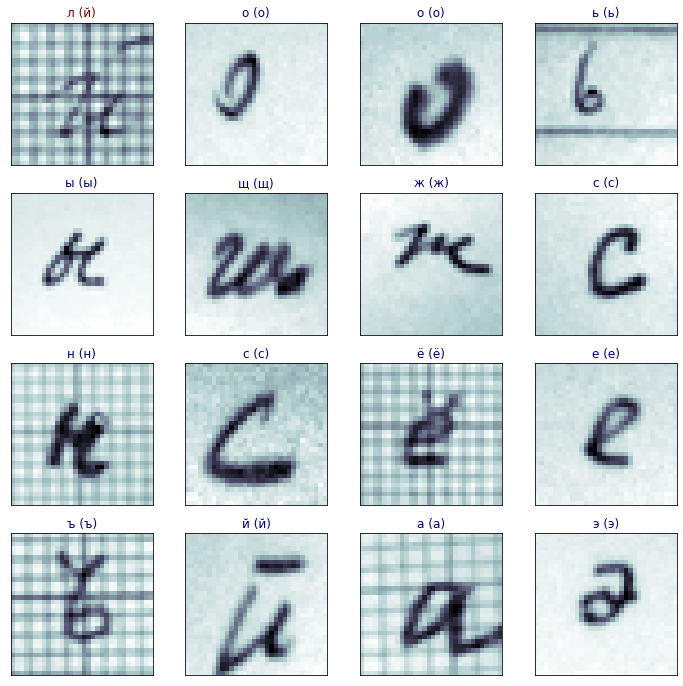

In [13]:
py_test1=gray_model.predict_classes(x_test1)
fig=pl.figure(figsize=(12,12))
for i,idx in enumerate(np.random.choice(x_test1.shape[0],
                                        size=16,replace=False)):
    ax=fig.add_subplot(4,4,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_test1[idx]),cmap=pl.cm.bone)
    pred_idx=py_test1[idx]
    true_idx=np.argmax(y_test1[idx])
    ax.set_title("{} ({})".format(letters[pred_idx],letters[true_idx]),
                 color=("darkblue" if pred_idx==true_idx else "darkred"))

# ✒️ Comparing with Multi-Label Classification

In [14]:
def gray_multi_model():    
    model_input=Input(shape=(32,32,1))
    x=BatchNormalization()(model_input)
    x=Conv2D(32,(5,5),padding='same')(model_input)
    x=LeakyReLU(alpha=.02)(x)
    x=MaxPooling2D(pool_size=(2,2))(x)    
    x=Dropout(.25)(x)   
    x=Conv2D(256,(5,5),padding='same')(x) 
    x=LeakyReLU(alpha=.02)(x)
    x=MaxPooling2D(pool_size=(2,2))(x)    
    x=Dropout(.25)(x)             
    x=GlobalMaxPooling2D()(x)    
    x=Dense(1024)(x) 
    x=LeakyReLU(alpha=.02)(x)
    x=Dropout(.25)(x)   
    x=Dense(256)(x) 
    x=LeakyReLU(alpha=.02)(x)
    x=Dropout(.025)(x)   
    y1=Dense(33,activation='softmax')(x)
    y2=Dense(4,activation='softmax')(x)      
    model=Model(inputs=model_input,outputs=[y1,y2])
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop',
                  metrics=[categorical_accuracy,top_3_categorical_accuracy])      
    return model
gray_multi_model=gray_multi_model()

In [15]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
history=gray_multi_model.fit(x_train2,y_train2_list,
                             epochs=200,batch_size=128,verbose=2,
                             validation_data=(x_valid2,y_valid2_list),
                             callbacks=[checkpointer,lr_reduction,estopping])

Train on 11352 samples, validate on 1419 samples
Epoch 1/200
 - 49s - loss: 4.5760 - dense_6_loss: 3.5023 - dense_7_loss: 1.0734 - dense_6_categorical_accuracy: 0.0314 - dense_6_top_3_categorical_accuracy: 0.0915 - dense_7_categorical_accuracy: 0.4725 - dense_7_top_3_categorical_accuracy: 0.9493 - val_loss: 4.5255 - val_dense_6_loss: 3.4962 - val_dense_7_loss: 1.0120 - val_dense_6_categorical_accuracy: 0.0345 - val_dense_6_top_3_categorical_accuracy: 0.0909 - val_dense_7_categorical_accuracy: 0.6110 - val_dense_7_top_3_categorical_accuracy: 0.9528

Epoch 00001: val_loss improved from inf to 4.52551, saving model to weights.best.letters.hdf5
Epoch 2/200
 - 49s - loss: 4.5143 - dense_6_loss: 3.4869 - dense_7_loss: 1.0272 - dense_6_categorical_accuracy: 0.0357 - dense_6_top_3_categorical_accuracy: 0.1095 - dense_7_categorical_accuracy: 0.5411 - dense_7_top_3_categorical_accuracy: 0.9523 - val_loss: 4.4365 - val_dense_6_loss: 3.4565 - val_dense_7_loss: 0.9667 - val_dense_6_categorical_accu

In [16]:
gray_multi_model.evaluate(x_test2,y_test2_list)

1419/1419 [==============================] - 2s 1ms/step


[0.28116116663828294,
 0.2518034279346466,
 0.028303654864430428,
 0.9267089366912842,
 0.9823819398880005,
 0.9929527640342712,
 1.0]